Kütüphanelerin import edilmesi

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

 

Veri setinin yüklenmesi

In [ ]:
data = pd.read_csv('data.csv')

İstenmeyen özelliklerin veri setinden kaldırılması

In [ ]:
data.drop(['Unnamed: 32','id'], inplace=True, axis= 1)

İstenen özellik kolonunun ismini değiştirme

In [ ]:
data = data.rename(columns= {'diagnosis':'target'})

Verinin özet kısmı

In [ ]:
data.head()

,target,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


İyi ve kötü huylu kanser sayıları.

B    357
M    212
Name: target, dtype: int64


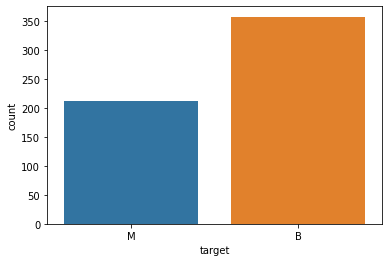

In [ ]:
sns.countplot(data['target'])
print(data.target.value_counts())

Targetleri kategorik olarak sayıya çevirme

In [ ]:
data['target'] = [ 1 if i.strip() == 'M' else 0 for i in data.target]

Veri Özeti

In [ ]:
print(len(data))
print(data.head())
print(data.shape)

569
   target  radius_mean  ...  symmetry_worst  fractal_dimension_worst
0       1        17.99  ...          0.4601                  0.11890
1       1        20.57  ...          0.2750                  0.08902
2       1        19.69  ...          0.3613                  0.08758
3       1        11.42  ...          0.6638                  0.17300
4       1        20.29  ...          0.2364                  0.07678

[5 rows x 31 columns]
(569, 31)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [ ]:
data.describe()

,target,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Verinin strandardization edilmesi gerek.

EDA

Text(0.5, 1.0, ' Korelasyon Matrisi')

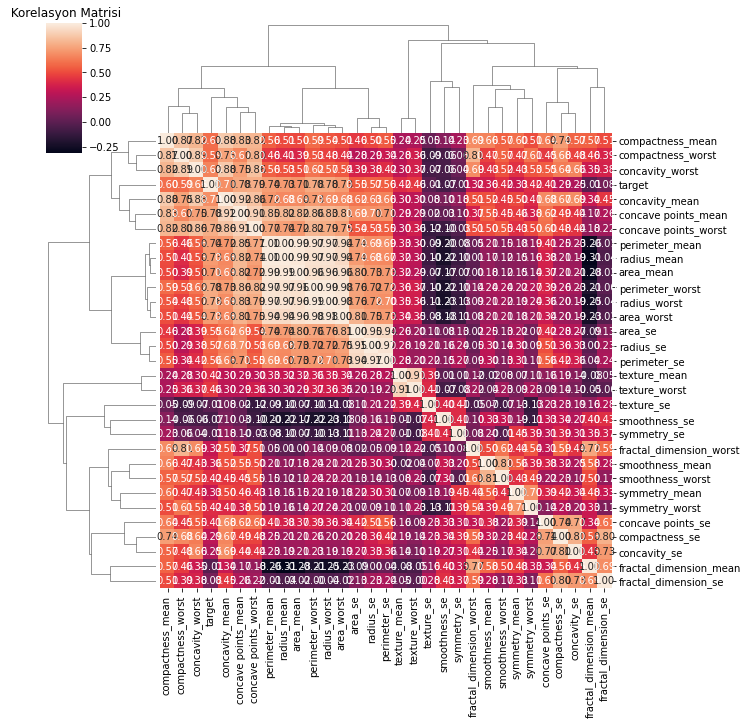

In [ ]:
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot = True, fmt =".2f")
plt.title(' Korelasyon Matrisi')

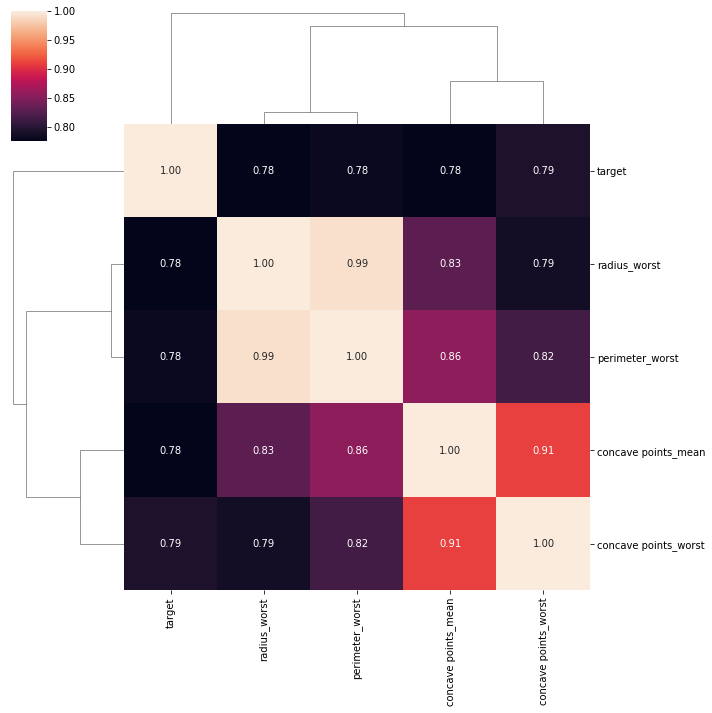

In [ ]:
threshold = 0.75
filtre = np.abs(corr_matrix['target']) > threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, fmt =".2f")


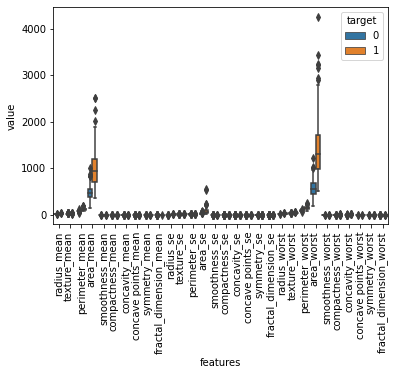

In [ ]:
data_melted = pd.melt(data, id_vars='target',
                      var_name = 'features',
                      value_name='value')

plt.figure()
sns.boxplot(x='features', y = 'value', hue  = 'target', data = data_melted)

plt.xticks(rotation = 90)

plt.show()

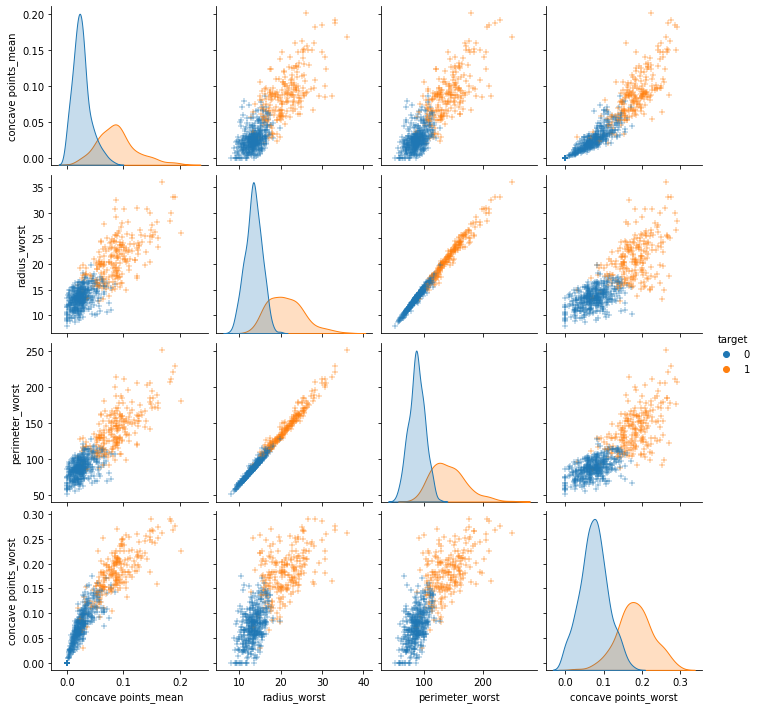

In [ ]:
sns.pairplot(data[corr_features], diag_kind = "kde", markers = "+",hue = "target")
plt.show()

Outlier veri setinde bulunan aykırı değerlerdir
Local ve Global olarak iki çeşit outlier vardır.
Density based ODS kullanacağız

In [ ]:
y = data.target
x= data.drop('target', axis= 1)
columns = x.columns.tolist()

In [ ]:
clf =  LocalOutlierFactor()
y_pred = clf.fit_predict(x)

In [ ]:
X_score  = clf.negative_outlier_factor_

outlier_score = pd.DataFrame()
outlier_score['score']  = X_score

In [ ]:
# threshold
threshold = -2.5
filtre = outlier_score["score"] < threshold
outlier_index = outlier_score[filtre].index.tolist()

In [ ]:
radius = (X_score.max() - X_score)/(X_score.max() - X_score.min())
outlier_score['radius']  = radius

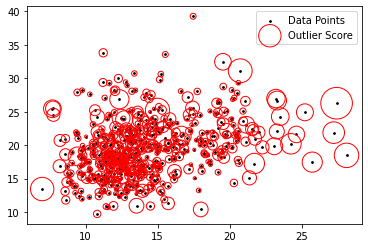

In [ ]:
plt.figure()
plt.scatter(x.iloc[:,0], x.iloc[:,1], color= 'k', s=3, label='Data Points')
plt.scatter(x.iloc[:,0], x.iloc[:,1], s= 1000*radius, edgecolors='r', facecolors='none', label='Outlier Score')
plt.legend()
plt.show()

In [ ]:
# drop outliers
x = x.drop(outlier_index)
y = y.drop(outlier_index).values

Verinin eğitim ve test olarak ayrılması

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.3, random_state=42)

Normalizasyon

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train_df = pd.DataFrame(X_train, columns=columns)
X_train_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.126206,-0.106331,-0.139113,-0.243152,0.200584,0.082163,-0.426589,-0.287204,-0.345793,0.802295,-0.314568,0.076317,-0.292073,-0.315855,-0.099643,-0.139109,-0.349512,0.253150,-0.203676,-0.011765,-0.243869,0.026662,-0.235439,-0.316803,0.456859,0.060010,-0.359469,0.218125,-0.054096,0.396185
1,1.110155,0.350378,1.085508,0.972350,0.516224,0.541814,0.433900,1.051074,0.668203,-0.276397,0.186356,-0.629822,0.107272,0.246608,0.057549,0.150266,-0.206766,0.458000,-0.757633,-0.159455,1.026425,-0.008771,0.960829,0.869669,0.705777,0.841678,0.340937,1.293014,0.281891,0.093907
2,-1.565931,-0.763715,-1.524658,-1.225782,1.326652,-0.408721,-0.589335,-0.780730,-0.582878,1.903286,-0.882480,-1.169058,-0.770054,-0.736836,0.386630,-0.160215,0.046329,-0.246173,-0.400476,0.009436,-1.410326,-0.941303,-1.316628,-1.082299,1.762589,-0.075060,-0.092330,-0.146403,0.068515,1.048258
3,0.567081,-0.251647,0.550500,0.456043,0.061958,0.213772,0.101004,0.286230,0.190385,-0.026932,1.121216,0.232318,0.863817,0.830982,-0.089739,-0.312956,-0.018463,-0.042923,-0.197602,-0.124239,0.779600,-0.031319,0.679317,0.656981,-0.027877,-0.160648,0.085079,0.112194,-0.144860,-0.103605
4,-0.487293,0.172769,-0.488764,-0.531209,-0.840888,-0.027839,-0.238905,-0.468792,-0.101412,-0.025539,-0.146725,-0.316504,-0.140456,-0.270829,-0.166418,0.481853,0.536659,0.334770,0.853216,0.313080,-0.594955,-0.385649,-0.585008,-0.592932,-1.180763,-0.212804,-0.375364,-0.594274,-0.315243,-0.329168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,-1.519135,-1.038202,-1.400385,-1.187933,0.106034,0.987715,-0.008229,-0.529056,0.339931,3.780546,0.456170,-0.669480,0.162265,-0.340174,3.245802,3.813831,0.860283,0.915713,0.611467,6.522147,-1.387984,-1.577487,-1.376024,-1.082299,-0.495145,-0.026916,-0.616353,-1.036536,-1.001549,1.431831
393,-0.724166,-0.187062,-0.710351,-0.701096,1.269780,-0.021946,-0.207733,-0.366317,-0.028463,0.352143,-0.363320,0.843164,-0.358374,-0.456230,0.475769,-0.106339,-0.059634,0.326768,-0.574195,0.021653,-0.663044,0.611307,-0.666059,-0.647204,1.605378,0.122865,0.121484,0.115309,-0.122567,0.433970
394,0.041338,-0.535360,-0.072975,-0.065175,-2.278331,-1.494204,-1.031853,-1.125587,-1.097171,-1.242204,-1.017573,-0.918329,-1.032224,-0.693399,-1.137048,-1.183302,-0.890596,-1.333160,-0.609425,-0.861968,-0.286425,-0.775413,-0.389807,-0.348523,-2.024903,-1.319041,-1.153400,-1.262886,-0.676708,-1.270352
395,-0.048211,0.110491,-0.038431,-0.160809,0.686840,0.205915,0.336486,0.424279,-0.509929,0.385591,-0.680398,-0.479460,-0.642592,-0.498849,-0.554926,-0.394603,-0.316103,-0.379485,-0.989663,-0.335532,0.166796,0.859338,0.212194,-0.009871,1.277853,0.730011,0.734724,1.064016,0.471382,1.265807


In [ ]:
X_train_df['target']  = Y_train

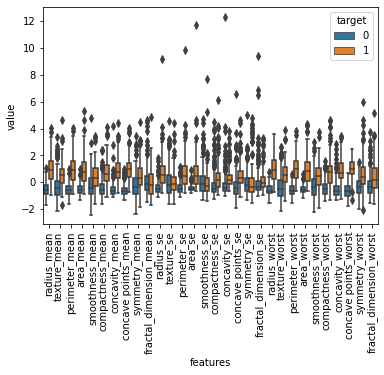

In [ ]:
data_melted = pd.melt(X_train_df, id_vars='target',
                      var_name = 'features',
                      value_name='value')

plt.figure()
sns.boxplot(x='features', y = 'value', hue  = 'target', data = data_melted)

plt.xticks(rotation = 90)

plt.show()

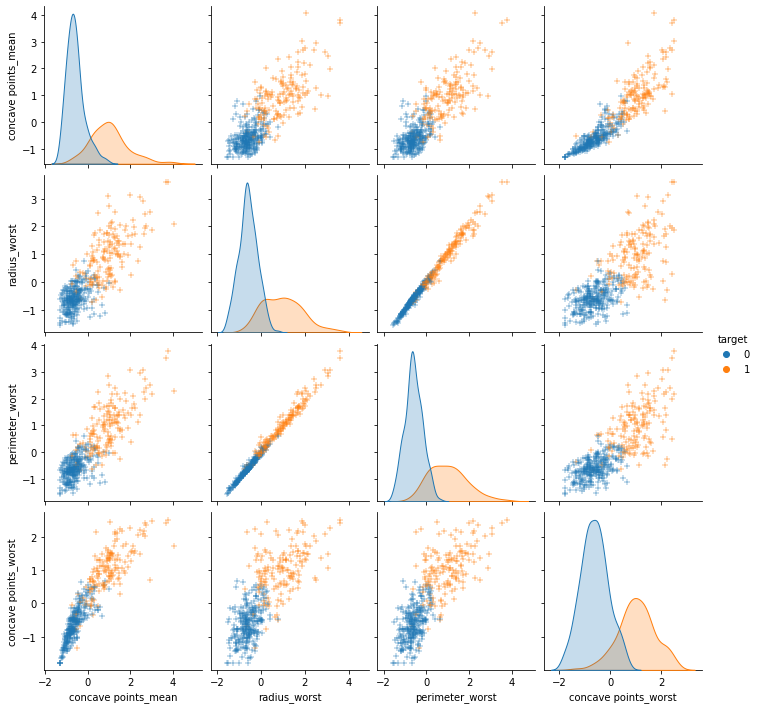

In [ ]:
sns.pairplot(data[corr_features], diag_kind = "kde", markers = "+",hue = "target")
plt.show()

In [30]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
acc = accuracy_score(Y_test, y_pred)
score = knn.score(X_test, Y_test)
print("Score: ",score)
print("CM: ",cm)
print("Basic KNN Acc: ",acc)

Score:  0.9532163742690059
CM:  [[108   1]
 [  7  55]]
Basic KNN Acc:  0.9532163742690059


In [31]:
def KNN_Best_Params(x_train, x_test, y_train, y_test):
    
    k_range = list(range(1,31))
    weight_options = ["uniform","distance"]
    print()
    param_grid = dict(n_neighbors = k_range, weights = weight_options)
    
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv = 10, scoring = "accuracy")
    grid.fit(x_train, y_train)
    
    print("Best training score: {} with parameters: {}".format(grid.best_score_, grid.best_params_))
    print()
    
    knn = KNeighborsClassifier(**grid.best_params_)
    knn.fit(x_train, y_train)
    
    y_pred_test = knn.predict(x_test)
    y_pred_train = knn.predict(x_train)
    
    cm_test = confusion_matrix(y_test, y_pred_test)
    cm_train = confusion_matrix(y_train, y_pred_train)
    
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    print("Test Score: {}, Train Score: {}".format(acc_test, acc_train))
    print()
    print("CM Test: ",cm_test)
    print("CM Train: ",cm_train)
    
    return grid
    
    
grid = KNN_Best_Params(X_train, X_test, Y_train, Y_test)


Best training score: 0.9670512820512821 with parameters: {'n_neighbors': 4, 'weights': 'uniform'}

Test Score: 0.9590643274853801, Train Score: 0.9773299748110831

CM Test:  [[107   2]
 [  5  57]]
CM Train:  [[248   0]
 [  9 140]]



Best training score: 0.9419230769230769 with parameters: {'n_neighbors': 9, 'weights': 'uniform'}

Test Score: 0.9239766081871345, Train Score: 0.947103274559194

CM Test:  [[103   6]
 [  7  55]]
CM Train:  [[241   7]
 [ 14 135]]


Text(0.5, 1.0, "2-Class classification (k = 9, weights = 'uniform')")

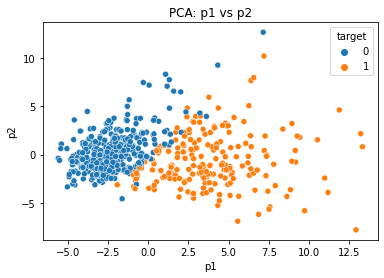

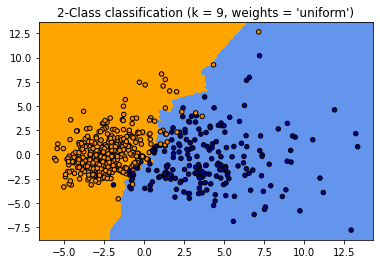

In [33]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(n_components = 2)
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)
pca_data = pd.DataFrame(X_reduced_pca, columns = ["p1","p2"])
pca_data["target"] = y
sns.scatterplot(x = "p1", y = "p2", hue = "target", data = pca_data)
plt.title("PCA: p1 vs p2")


X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_reduced_pca, y, test_size = 0.3, random_state = 42)

grid_pca = KNN_Best_Params(X_train_pca, X_test_pca, Y_train_pca, Y_test_pca)

# visualize 
cmap_light = ListedColormap(['orange',  'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

h = .05 # step size in the mesh
X = X_reduced_pca
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = grid_pca.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class classification (k = %i, weights = '%s')"
          % (len(np.unique(y)),grid_pca.best_estimator_.n_neighbors, grid_pca.best_estimator_.weights))